<a href="https://colab.research.google.com/github/1kaiser/test2023/blob/main/Jan_2023_6_OpenAltimetry_and_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Python programming for Google Earth Engine*
# **OpenAltimetry and Google Earth Engine**

## OBJECTIVES
- Load ICESat-2 data using the OpenAltimetry API.
- Query Google Earth Engine for geospatial raster data and display it along with ICESat-2 ground tracks on an interactive map.
- Better understand what you are looking at in ATL03 features without downloading a bunch of files.

## CREDITS
- This tutorial is originally credited by Wei Ji Leong, Scott Henderson, and Philipp Arndt.
- This tutorial was the part of 2022 ICESat-2 Hackweek [ICESat-2 Hackweek](https://icesat-2.hackweek.io/), and modified by YoungHyun Koo for the UTSA Remote Sensing Image Processing course.
- Original Python script: [Interactive Visualizion with Open Altimetry & Google Earth Engine](https://github.com/ICESAT-2HackWeek/website2022/blob/main/book/tutorials/DataVisualization/Visualization_Earth_Engine_geemap_IS2_HW_2022.ipynb) and [OpenAltimery and GEE Use Examples](https://github.com/ICESAT-2HackWeek/website2022/blob/main/book/tutorials/DataVisualization/Visualization_geemap_use_examples.ipynb).
- More information about ICESat-2 Hackweek: [ICESat-2 Hackweek GitHub](https://github.com/ICESAT-2HackWeek/website2022)

#**1. Install & Import necessary libraries and functions**


In [ ]:
!pip install geemap  # for visualization of maps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.1/198.1 KB 12.2 MB/s eta 0:00:00
  Preparing metadata (

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 35.5 MB/s eta 0:00:00


In [ ]:
import os
import ee
import geemap
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
import rasterio as rio
from rasterio import plot
from rasterio import warp

In [ ]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

def _rect_inter_inner(x1, x2):
    n1 = x1.shape[0]-1
    n2 = x2.shape[0]-1
    X1 = np.c_[x1[:-1], x1[1:]]
    X2 = np.c_[x2[:-1], x2[1:]]
    S1 = np.tile(X1.min(axis=1), (n2, 1)).T
    S2 = np.tile(X2.max(axis=1), (n1, 1))
    S3 = np.tile(X1.max(axis=1), (n2, 1)).T
    S4 = np.tile(X2.min(axis=1), (n1, 1))
    return S1, S2, S3, S4


def _rectangle_intersection_(x1, y1, x2, y2):
    S1, S2, S3, S4 = _rect_inter_inner(x1, x2)
    S5, S6, S7, S8 = _rect_inter_inner(y1, y2)

    C1 = np.less_equal(S1, S2)
    C2 = np.greater_equal(S3, S4)
    C3 = np.less_equal(S5, S6)
    C4 = np.greater_equal(S7, S8)

    ii, jj = np.nonzero(C1 & C2 & C3 & C4)
    return ii, jj


def intersection(x1, y1, x2, y2):

    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    ii, jj = _rectangle_intersection_(x1, y1, x2, y2)
    n = len(ii)

    dxy1 = np.diff(np.c_[x1, y1], axis=0)
    dxy2 = np.diff(np.c_[x2, y2], axis=0)

    T = np.zeros((4, n))
    AA = np.zeros((4, 4, n))
    AA[0:2, 2, :] = -1
    AA[2:4, 3, :] = -1
    AA[0::2, 0, :] = dxy1[ii, :].T
    AA[1::2, 1, :] = dxy2[jj, :].T

    BB = np.zeros((4, n))
    BB[0, :] = -x1[ii].ravel()
    BB[1, :] = -x2[jj].ravel()
    BB[2, :] = -y1[ii].ravel()
    BB[3, :] = -y2[jj].ravel()

    for i in range(n):
        try:
            T[:, i] = np.linalg.solve(AA[:, :, i], BB[:, i])
        except:
            T[:, i] = np.Inf

    in_range = (T[0, :] >= 0) & (T[1, :] >= 0) & (
        T[0, :] <= 1) & (T[1, :] <= 1)

    xy0 = T[2:, in_range]
    xy0 = xy0.T
    return xy0[:, 0], xy0[:, 1]

class dataCollector:
    def __init__(self, beam=None, oaurl=None, track=None, date=None, latlims=None, lonlims=None, verbose=False):
        if (beam is None) or ((oaurl is None) and (None in [track, date, latlims, lonlims])):
            raise Exception('''Please specify a beam and 
            - either: an OpenAltimetry API url, 
            - or: a track, date, latitude limits and longitude limits.''')
        else:
            if oaurl is not None:
                url = oaurl
                tofind = '&beamName='
                ids = url.find(tofind)
                while ids>-1:
                    url = url.replace(url[ids:ids+len(tofind)+4],'')
                    ids = url.find(tofind)
                iprod = url.find('/atl')
                url = url.replace(url[iprod:iprod+6],'/atlXX')
                url += tofind + beam + '&client=jupyter'

                idate = url.find('date=') + len('date=')
                date = url[idate:idate+10]
                itrack = url.find('trackId=') + len('trackId=')
                trackend = url[itrack:].find('&')
                track = int(url[itrack:itrack+trackend])
                bb = []
                for s in ['minx=', 'maxx=', 'miny=', 'maxy=']:
                    ids = url.find(s) + len(s)
                    ide = url[ids:].find('&')
                    bb.append(float(url[ids:ids+ide]))
                lonlims = bb[:2]
                latlims = bb[2:]
            elif None not in [track, date, latlims, lonlims]:
                url = 'https://openaltimetry.org/data/api/icesat2/atlXX?'
                url += 'date={date}&minx={minx}&miny={miny}&maxx={maxx}&maxy={maxy}&trackId={track}&beamName={beam}'.format(
                        date=date,minx=lonlims[0],miny=latlims[0],maxx=lonlims[1],maxy=latlims[1],track=track,beam=beam)
                url += '&outputFormat=json&client=jupyter'
            
            self.url = url
            self.date = date
            self.track = track
            self.beam = beam
            self.latlims = latlims
            self.lonlims = lonlims
            if verbose:
                print('OpenAltimetry API URL:', self.url)
                print('Date:', self.date)
                print('Track:', self.track)
                print('Beam:', self.beam)
                print('Latitude limits:', self.latlims)
                print('Longitude limits:', self.lonlims)
            
    def requestData(self, verbose=False): 
        if verbose:
            print('---> requesting ATL03 data...',end='')
        product = 'atl03'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        lat, lon, h, confs = [], [], [], []
        for beam in data:
            for confidence in beam['series']:
                for p in confidence['data']:
                    confs.append(confidence['name'])
                    lat.append(p[0])
                    lon.append(p[1])
                    h.append(p[2])
        self.atl03 = pd.DataFrame(list(zip(lat,lon,h,confs)), columns = ['lat','lon','h','conf'])
        if verbose:
            print(' Done.')
            
            print('---> requesting ATL06 data...',end='')
        product = 'atl06'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl06 = pd.DataFrame(data['series'][0]['lat_lon_elev'], columns = ['lat','lon','h'])
        if verbose:
            print(' Done.')
            
            print('---> requesting ATL08 data...',end='')
        product = 'atl08'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl08 = pd.DataFrame(data['series'][0]['lat_lon_elev_canopy'], columns = ['lat','lon','h','canopy'])
        if verbose:
            print(' Done.')
    
    ################################################################################################ 
    def plotData(self,ax=None,title='some Data I found on OpenAltimetry'):

        # get data if not already there
        if 'atl03' not in vars(self).keys(): 
            print('Data has not yet been requested from OpenAltimetry yet. Doing this now.')
            self.requestData(verbose=True)

        axes_not_specified = True if ax == None else False

        # create the figure and axis
        if axes_not_specified:
            fig, ax = plt.subplots(figsize=[10,6])
        atl03 = ax.scatter(self.atl03.lat, self.atl03.h, s=2, color='black', alpha=0.2, label='ATL03')
        atl06, = ax.plot(self.atl06.lat, self.atl06.h, label='ATL06')
        atl08, = ax.plot(self.atl08.lat, self.atl08.h, label='ATL08', linestyle='--')

        heights = self.atl03.h[self.atl03.conf != 'Noise']
        y_min1 = np.min(heights)
        y_max1 = np.max(heights)
        maxprods = np.nanmax((self.atl06.h.max(), self.atl08.h.max()))
        minprods = np.nanmin((self.atl06.h.min(), self.atl08.h.min()))
        hrange = maxprods - minprods
        y_min2 = minprods - hrange * 0.5
        y_max2 = maxprods + hrange * 0.5
        y_min = np.nanmin((y_min1, y_min2))
        y_max = np.nanmax((y_max1, y_max2))

        x_min = self.atl08.lat.min()
        x_max = self.atl08.lat.max()

        ax.set_xlim((x_min, x_max))
        ax.set_ylim((y_min, y_max))

        # label the axes
        ax.set_title(title)
        ax.set_xlabel('latitude')
        ax.set_ylabel('elevation in meters')

        # add a legend
        ax.legend(loc='lower right')

        # add some text to provide info on what is plotted
        info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}\n({lon:.4f}E, {lat:.4f}N)'.format(track=self.track, 
                                                                                                beam=self.beam, 
                                                                                                date=self.date, 
                                                                                                lon=np.mean(self.lonlims), 
                                                                                                lat=np.mean(self.latlims))
        infotext = ax.text(0.03, 0.03, info,
                           horizontalalignment='left', 
                           verticalalignment='bottom', 
                           transform=ax.transAxes,
                           fontsize=7,
                           bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

        if axes_not_specified:
            fig.tight_layout()
            return fig
        else:
            return ax

    ################################################################################################        
    def plotData_hv(self):
        import holoviews as hv
        from holoviews import opts
        hv.extension('bokeh', 'matplotlib')
        
        confdict = {'Noise': -1.0, 'Buffer': 0.0, 'Low': 1.0, 'Medium': 2.0, 'High': 3.0}
        self.atl03['conf_num'] = [confdict[x] for x in self.atl03.conf]
        self.atl08['canopy_h'] = self.atl08.h + self.atl08.canopy
        atl03scat = hv.Scatter(self.atl03, 'lat', vdims=['h', 'conf_num'], label='ATL03')\
                    .opts(color='conf_num', alpha=1, cmap='dimgray_r')
        atl06line = hv.Curve(self.atl06, 'lat', 'h', label='ATL06')\
                    .opts(color='r', alpha=0.5, line_width=3)
        atl08line = hv.Curve(self.atl08, 'lat', 'h', label='ATL08')\
                    .opts(color='b', alpha=1, line_width=1)
        atl08scat = hv.Scatter(self.atl08, 'lat', 'canopy_h', label='ATL08 Canopy')
        atl08scat = atl08scat.opts(alpha=1, color='g', size=4)
        hrange = self.atl06.h.max() - self.atl06.h.min()
        overlay = (atl03scat * atl06line * atl08line * atl08scat).opts(
            height=500, 
            width=800,
            xlabel='latitude', 
            ylabel='elevation', 
            title='ICESat-2 track %d %s on %s' % (self.track,self.beam.upper(),self.date),
            legend_position='bottom_right',
            ylim=(self.atl06.h.min()-hrange, self.atl06.h.max()+hrange),
            xlim=(self.atl06.lat.min(), self.atl06.lat.max())
        )
        return overlay
    
    ################################################################################################
    def makeGEEmap(self, days_buffer=25):

        # get data if not already there
        if 'atl03' not in vars(self).keys(): 
            print('Data has not yet been requested from OpenAltimetry yet. Doing this now.')
            self.requestData(verbose=True)

        def dist_latlon2meters(lat1, lon1, lat2, lon2):
            # returns the distance between two lat/lon coordinate points along the earth's surface in meters
            R = 6371000
            def deg2rad(deg):
                return deg * (np.pi/180)
            dlat = deg2rad(lat2-lat1)
            dlon = deg2rad(lon2-lon1)
            a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            return R * c

        lat1, lat2 = self.atl08.lat[0], self.atl08.lat.iloc[-1]
        lon1, lon2 = self.atl08.lon[0], self.atl08.lon.iloc[-1]
        center_lat = (lat1 + lat2) / 2
        center_lon = (lon1 + lon2) / 2
        ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
        print('The ground track is %d meters long.' % np.round(ground_track_length))

        collection_name1 = 'COPERNICUS/S2_SR'  # Sentinel-2 earth engine collection 
        # https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

        collection_name2 = 'LANDSAT/LC08/C01/T2'  # Landsat 8 earth engine collection 
        # https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2
        # Note: Landsat 8 ingestion into Earth Engine seems to not have reached Antarctica yet, so using raw scenes...

        # the point of interest (center of the track) as an Earth Engine Geometry
        point_of_interest = ee.Geometry.Point(center_lon, center_lat)

        def query_scenes(self, days_buffer):
            # get the dates
            datetime_requested = datetime.strptime(self.date, '%Y-%m-%d')
            search_start = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
            search_end = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
            print('Search for imagery from {start:s} to {end:s}.'.format(start=search_start, end=search_end))

            # the collection to query: 
            # 1) merge Landsat 8 and Sentinel-2 collections
            # 2) filter by acquisition date
            # 3) filter by the point of interest
            # 4) sort by acquisition date
            collection = ee.ImageCollection(collection_name1) \
                .merge(ee.ImageCollection(collection_name2)) \
                .filterDate(search_start, search_end) \
                .filterBounds(point_of_interest) \
                .sort('system:time_start') 

            info = collection.getInfo()
            n_imgs = len(info['features'])
            print('--> Number of scenes found within +/- %d days of ICESat-2 overpass: %d' % (days_buffer, n_imgs))

            return (collection, info, n_imgs)

        # query collection for initial days_buffer
        collection, info, n_imgs = query_scenes(self, days_buffer)

        # if query returns more than 20 images, try to narrow it down
        tries = 0
        while (n_imgs > 20) & (tries<5): 
            print('----> This is too many. Narrowing it down...')
            days_buffer = np.round(days_buffer * 15 / n_imgs)
            collection, info, n_imgs = query_scenes(self, days_buffer)
            n_imgs = len(info['features'])
            tries += 1

        # if query returns no images, then return
        if n_imgs < 1: 
            print('NO SCENES FOUND. Try to widen your search by including more dates.')
            return

        # region of interest around the ground track (use this area to scale visualization factors)
        buffer_around_center_meters = ground_track_length/2
        region_of_interest = point_of_interest.buffer(buffer_around_center_meters)

        # make an earth engine feature collection from the ground track so we can show it on the map
        ground_track_coordinates = list(zip(self.atl08.lon, self.atl08.lat))
        ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
        gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates,
                                                                  proj=ground_track_projection,
                                                                  geodesic=True))

        Map = geemap.Map(center=(40, -100), zoom=4)
        Map.add_basemap('HYBRID')

        for i, feature in enumerate(info['features']):

            # get the relevant info
            thisDate = datetime.fromtimestamp(feature['properties']['system:time_start']/1e3)
            dtstr = thisDate.strftime('%Y-%m-%d')
            dt = (thisDate - datetime.strptime(self.date, '%Y-%m-%d')).days
            ID = feature['id']
            rel = 'before' if dt<0 else 'after'
            print('%02d: %s (%3d days %s ICESat-2 overpass): %s' % (i, dtstr, np.abs(dt), rel, ID))

            # get image by id, and normalize rgb range
            image_id = feature['id']
            thisScene = ee.Image(image_id)
            rgb = thisScene.select('B4', 'B3', 'B2')
            rgbmax = rgb.reduce(ee.Reducer.max()).reduceRegion(reducer=ee.Reducer.max(), geometry=region_of_interest, bestEffort=True, maxPixels=1e6)
            rgbmin = rgb.reduce(ee.Reducer.min()).reduceRegion(reducer=ee.Reducer.min(), geometry=region_of_interest, bestEffort=True, maxPixels=1e6)
            rgb = rgb.unitScale(ee.Number(rgbmin.get('min')), ee.Number(rgbmax.get('max'))).clamp(0.0, 1.0)

            # if the image is Landsat 8, then pan-sharpen the image
            if 'LANDSAT' in ID: 
                pan = thisScene.select('B8').unitScale(ee.Number(rgbmin.get('min')), ee.Number(rgbmax.get('max'))).clamp(0.0, 1.0)
                huesat = rgb.rgbToHsv().select('hue', 'saturation')
                rgb = ee.Image.cat(huesat, pan).hsvToRgb().clamp(0.0, 1.0)

            # make the image uint8
            rgb = rgb.multiply(255).uint8()

            # add to map (only show the first layer, then can toggle others on in map)
            show_layer = True if i==0 else False
            Map.addLayer(rgb, name='%02d: %d days, %s'%(i,dt,ID), shown=show_layer)

        # show ground track on map, and center on our region of interest
        Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')
        Map.centerObject(region_of_interest,zoom=11)

        return Map
    
    ################################################################################################
    def plotDataAndMap(self, scene_id, crs='EPSG:3857', title='ICESat-2 Data'):

        # from utils.curve_intersect import intersection

        # get data if not already there
        if 'atl03' not in vars(self).keys(): 
            print('Data has not yet been requested from OpenAltimetry yet. Doing this now.')
            self.requestData(verbose=True)

        # plot the ICESat-2 data
        fig = plt.figure(figsize=[12,5])
        ax_data = fig.add_subplot(122)
        self.plotData(ax_data, title=title)

        # get the image and plot
        ax_img = fig.add_subplot(121)

        def dist_latlon2meters(lat1, lon1, lat2, lon2):
            # returns the distance between two lat/lon coordinate points along the earth's surface in meters
            R = 6371000
            def deg2rad(deg):
                return deg * (np.pi/180)
            dlat = deg2rad(lat2-lat1)
            dlon = deg2rad(lon2-lon1)
            a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            return R * c

        lat1, lat2 = self.atl08.lat[0], self.atl08.lat.iloc[-1]
        lon1, lon2 = self.atl08.lon[0], self.atl08.lon.iloc[-1]
        center_lat = (lat1 + lat2) / 2
        center_lon = (lon1 + lon2) / 2
        ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)

        # the point of interest (center of the track) as an Earth Engine Geometry
        point_of_interest = ee.Geometry.Point(center_lon, center_lat)

        # region of interest around the ground track (use this area to scale visualization factors)
        buffer_around_center_meters = ground_track_length*0.52
        region_of_interest = point_of_interest.buffer(buffer_around_center_meters)

        thisScene = ee.Image(scene_id)
        info = thisScene.getInfo()

        # get the relevant info
        thisDate = datetime.fromtimestamp(info['properties']['system:time_start']/1e3)
        dtstr = thisDate.strftime('%Y-%m-%d')

        download_folder = 'downloads/'
        download_filename = '%s%s-8bitRGB.tif' % (download_folder, scene_id.replace('/', '-'))

        if os.path.exists(download_filename):
            print('This file already exists, not downloading again: %s' % download_filename)
        else:
            # get image by id, and normalize rgb range
            rgb = thisScene.select('B4', 'B3', 'B2')
            rgbmax = rgb.reduce(ee.Reducer.max()).reduceRegion(reducer=ee.Reducer.max(), geometry=region_of_interest, bestEffort=True, maxPixels=1e6)
            rgbmin = rgb.reduce(ee.Reducer.min()).reduceRegion(reducer=ee.Reducer.min(), geometry=region_of_interest, bestEffort=True, maxPixels=1e6)
            rgb = rgb.unitScale(ee.Number(rgbmin.get('min')), ee.Number(rgbmax.get('max'))).clamp(0.0, 1.0)

            # if the image is Landsat 8, then pan-sharpen the image
            if 'LANDSAT' in scene_id: 
                pan = thisScene.select('B8').unitScale(ee.Number(rgbmin.get('min')), ee.Number(rgbmax.get('max'))).clamp(0.0, 1.0)
                huesat = rgb.rgbToHsv().select('hue', 'saturation')
                rgb = ee.Image.cat(huesat, pan).hsvToRgb().clamp(0.0, 1.0)

            # make the image uint8
            rgb = rgb.multiply(255).uint8()

            rgb_info = rgb.getInfo()
            downloadURL = rgb.getDownloadUrl({'name': 'mySatelliteImage',
                                          'crs': crs,
                                          'scale': rgb_info['bands'][0]['crs_transform'][0],
                                          'region': region_of_interest,
                                          'filePerBand': False,
                                          'format': 'GEO_TIFF'})

            response = requests.get(downloadURL)

            if not os.path.exists(download_folder): os.makedirs(download_folder)
            with open(download_filename, 'wb') as fd:
                fd.write(response.content)

            print('Downloaded %s' % download_filename)

        img = rio.open(download_filename)
        plot.show(img, ax=ax_img)

        # get the graticule right
        latlon_bbox = warp.transform(img.crs, {'init': 'epsg:4326'}, 
                                     [img.bounds[i] for i in [0,2,2,0,0]], 
                                     [img.bounds[i] for i in [1,1,3,3,1]])
        min_lat = np.min(latlon_bbox[1])
        max_lat = np.max(latlon_bbox[1])
        min_lon = np.min(latlon_bbox[0])
        max_lon = np.max(latlon_bbox[0])
        latdiff = max_lat-min_lat
        londiff = max_lon-min_lon
        diffs = np.array([0.0001, 0.0002, 0.00025, 0.0004, 0.0005,
                          0.001, 0.002, 0.0025, 0.004, 0.005, 
                          0.01, 0.02, 0.025, 0.04, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 1, 2])
        latstep = np.min(diffs[diffs>latdiff/8])
        lonstep = np.min(diffs[diffs>londiff/8])
        minlat = np.floor(min_lat/latstep)*latstep
        maxlat = np.ceil(max_lat/latstep)*latstep
        minlon = np.floor(min_lon/lonstep)*lonstep
        maxlon = np.ceil(max_lon/lonstep)*lonstep

        # plot meridians and parallels
        xl = (img.bounds.left, img.bounds.right)
        yl = (img.bounds.bottom, img.bounds.top)
        meridians = np.arange(minlon,maxlon, step=lonstep)
        parallels = np.arange(minlat,maxlat, step=latstep)
        latseq = np.linspace(minlat,maxlat,200)
        lonseq = np.linspace(minlon,maxlon,200)
        gridcol = 'k'
        gridls = ':'
        gridlw = 0.5
        topline = [[xl[0],xl[1]],[yl[1],yl[1]]]
        bottomline = [[xl[0],xl[1]],[yl[0],yl[0]]]
        leftline = [[xl[0],xl[0]],[yl[0],yl[1]]]
        rightline = [[xl[1],xl[1]],[yl[0],yl[1]]]
        for me in meridians:
            gr_trans = warp.transform({'init': 'epsg:4326'},img.crs,me*np.ones_like(latseq),latseq)
            intx,inty = intersection(leftline[0], leftline[1], gr_trans[0], gr_trans[1])
            deglab = '%.10g°E' % me if me >= 0 else '%.10g°W' % -me
            if len(intx) > 0:
                intx = intx[0]
                inty = inty[0]
                ax_img.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='center',horizontalalignment='right',
                        rotation='vertical')
            intx,inty = intersection(bottomline[0], bottomline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx = intx[0]
                inty = inty[0]
                ax_img.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='top',horizontalalignment='center',
                        rotation='vertical')
            thislw = gridlw
            ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
        for pa in parallels:
            gr_trans = warp.transform({'init': 'epsg:4326'},img.crs,lonseq,pa*np.ones_like(lonseq))
            thislw = gridlw
            deglab = '%.10g°N' % pa if pa >= 0 else '%.10g°S' % -pa
            intx,inty = intersection(topline[0], topline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx = intx[0]
                inty = inty[0]
                ax_img.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='bottom',horizontalalignment='center')
            intx,inty = intersection(rightline[0], rightline[1], gr_trans[0], gr_trans[1])
            if len(intx) > 0:
                intx = intx[0]
                inty = inty[0]
                ax_img.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='center',horizontalalignment='left')
            ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)

        ax_img.text(0.99, 0.01, scene_id, fontsize=6, color='k',verticalalignment='bottom',horizontalalignment='right',transform=ax_img.transAxes)
        ax_img.set_xlim(xl)
        ax_img.set_ylim(yl)

        # plot the ground track
        gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=img.crs, xs=self.atl08.lon, ys=self.atl08.lat)
        ax_img.plot(gtx_x, gtx_y, color='red', linestyle='-')
        ax_img.axis('off')

        lengths_scalebar = np.array([0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 500, 1000])
        ratios = lengths_scalebar / (0.9*ground_track_length/1000)
        lengths_scalebar = lengths_scalebar[ratios < 1]
        length_scalebar = lengths_scalebar[-1]
        xl = ax_data.get_xlim()
        yl = ax_data.get_ylim()
        mid_lat = np.mean(xl)
        len_lat = (xl[1]-xl[0]) * (length_scalebar / ground_track_length*1000)
        h_scale = yl[0] + 0.93 * (yl[1]-yl[0])
        ax_data.arrow(mid_lat-0.5*len_lat,h_scale,len_lat,0,#head_width=3, head_length=5, 
                 fc='k', ec='k',lw=1,ls='-',length_includes_head=True,snap=True)
        ax_data.text(mid_lat, h_scale, '%.10g km' % (length_scalebar),va='bottom',ha='center')

        fig.tight_layout()
        
        plots_folder = 'plots/'
        if not os.path.exists(plots_folder): os.makedirs(plots_folder)
        plot_filename = '%s%s-8bitRGB-plot.jpg' % (plots_folder, scene_id.replace('/', '-'))
        fig.savefig(plot_filename,dpi=600)
        print('Saved plot to: %s' % plot_filename)

        return fig

def plot_from_oa_url(url,gtx,title='ICESat-2 Data'):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    myplot = mydata.plotData(title=title)
    return (myplot, mydata)

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=km7IawZorUdlkDyjbCAJWdrelD8HPy7Fx7Wjx-FhHlw&tc=KFAol_n10nUsHq_jKr24xZpn7Y5pCBBXg15EYR3YZDQ&cc=IYJxLHgGrkshE30erVX8pcy9xj22u5IkD6ytCsyhiN8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWgavdcZrkIuq1XbWaRboU5SKXx0eGWFMHBjRe91dnm2ESQfk5TkF02zjCo

Successfully saved authorization token.


#**2. Use OpenAltimetry API**

I went to [OpenAltimetry](https://openaltimetry.org/) and selected BROWSE ICESAT-2 DATA. Then I selected ATL 06 (Land Ice Height) on the top right, and switched the projection🌎 to Antarctic. Then I selected **January 16, 2020** in the calendar📅 on the bottom left, and toggled the cloud☁️ button to show MODIS imagery of that date. I then zoomed in on my region of interest (Nivlisen Ice Shelf). Looks like there's a cloud in MODIS, but ICESat-2 has data. I wonder what this cloud is hiding?🤔

To find out, I clicked on SELECT A REGION on the top left, and drew a rectangle around that mysterious cloud. When right-clicking on that rectangle, I could select View Elevation profile. This opened a new tab, and showed me ATL06 and ATL08 elevations.

It looks like ATL06 can't decide where the surface is, and ATL08 tells me that there's a forest canopy on this ice shelf in Antarctica?? To get to the bottom of this, I scrolled all the way down and selected 🛈Get API URL. The website confirms that the "API endpoint was copied to clipboard." Now I can use this to access the data myself.

Note: Instead of trying to find Nivlisen Ice Shelf yourself, you can access the OpenAltimetry page shown above by going to this annotation🏷️. Just left-click on the red box and select "View Elevation Profile".

## Access data

Access IS2data from OpenAltimetry

In [ ]:
# paste the API URL from OpenAltimetry below, and specify the beam you are interested in
oa_api_url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2r'

In [ ]:
is2data = dataCollector(oaurl=oa_api_url,beam=gtx, verbose=True)

OpenAltimetry API URL: http://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&outputFormat=json&beamName=gt2r&client=jupyter
Date: 2020-01-16
Track: 312
Beam: gt2r
Latitude limits: [-70.34956862465471, -70.2449105354736]
Longitude limits: [12.107692195781404, 12.426364789894341]


Another way to access IS2data

In [ ]:
latlims = [-70.34957, -70.24491]
lonlims = [12.10769, 12.42636]
rgt = 312
gtx = 'gt2r'
date = '2020-01-16'
is2data = dataCollector(date=date, latlims=latlims, lonlims=lonlims, track=rgt, beam=gtx, verbose=True)

OpenAltimetry API URL: https://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.10769&miny=-70.34957&maxx=12.42636&maxy=-70.24491&trackId=312&beamName=gt2r&outputFormat=json&client=jupyter
Date: 2020-01-16
Track: 312
Beam: gt2r
Latitude limits: [-70.34957, -70.24491]
Longitude limits: [12.10769, 12.42636]


Request Data

In [ ]:
is2data.requestData(verbose=True)

---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.


In [ ]:
vars(is2data)

{'url': 'https://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.10769&miny=-70.34957&maxx=12.42636&maxy=-70.24491&trackId=312&beamName=gt2r&outputFormat=json&client=jupyter',
 'date': '2020-01-16',
 'track': 312,
 'beam': 'gt2r',
 'latlims': [-70.34957, -70.24491],
 'lonlims': [12.10769, 12.42636],
 'atl03':              lat        lon           h   conf
 0     -70.244852  12.299888  248.103740  Noise
 1     -70.244859  12.299886  261.201020  Noise
 2     -70.244865  12.299884  243.059620  Noise
 3     -70.244862  12.299884  118.523254  Noise
 4     -70.244859  12.299884    9.918441  Noise
 ...          ...        ...         ...    ...
 46111 -70.349453  12.260788   44.356140   High
 46112 -70.349459  12.260786   45.128857   High
 46113 -70.349472  12.260782   44.818504   High
 46114 -70.349472  12.260782   45.072422   High
 46115 -70.349478  12.260779   44.981472   High
 
 [46116 rows x 4 columns],
 'atl06':            lat        lon          h
 0   -70.245025  12.2

## Plot the ATL03, ATL06, and ATL08 data

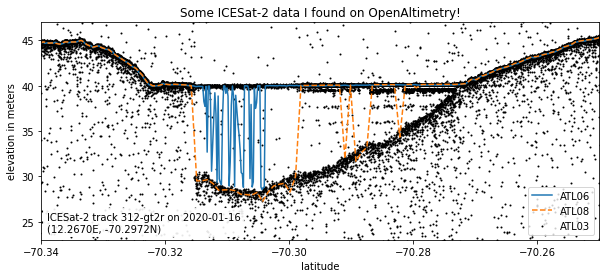

In [ ]:
# create the figure and axis
fig, ax = plt.subplots(figsize=[10,4])
atl06, = ax.plot(is2data.atl06.lat, is2data.atl06.h, label='ATL06')
atl08, = ax.plot(is2data.atl08.lat, is2data.atl08.h, label='ATL08', linestyle='--')
atl03 = ax.scatter(is2data.atl03.lat, is2data.atl03.h, s=1, color='black', label='ATL03')

ax.set_xlim((-70.34, -70.25))
ax.set_ylim((23, 47))

ax.set_xlabel('latitude')
ax.set_ylabel('elevation in meters')
ax.set_title('Some ICESat-2 data I found on OpenAltimetry!')

ax.legend(loc='lower right')

# add some text to provide info on what is plotted
info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}\n({lon:.4f}E, {lat:.4f}N)'.format(track=is2data.track, 
                                                                                        beam=is2data.beam, 
                                                                                        date=is2data.date, 
                                                                                        lon=np.mean(is2data.lonlims), 
                                                                                        lat=np.mean(is2data.latlims))
infotext = ax.text(0.01, 0.03, info,
                   horizontalalignment='left', 
                   verticalalignment='bottom', 
                   transform=ax.transAxes,
                   bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

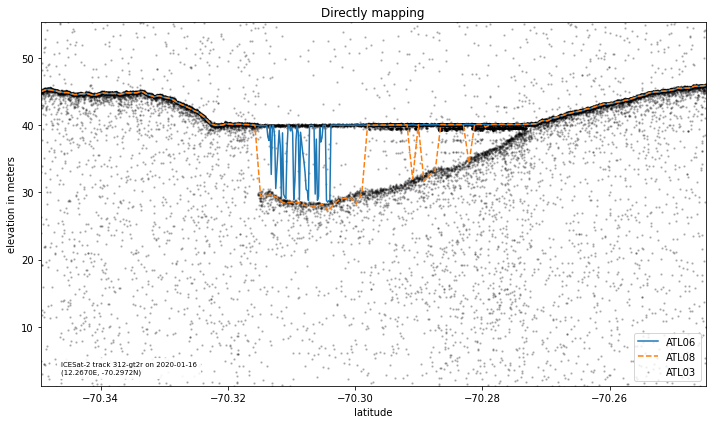

In [ ]:
url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Directly mapping')

In [ ]:
def dist_latlon2meters(lat1, lon1, lat2, lon2):
    # returns the distance between two coordinate points - (lon1, lat1) and (lon2, lat2) along the earth's surface in meters.
    R = 6371000
    def deg2rad(deg):
        return deg * (np.pi/180)
    dlat = deg2rad(lat2-lat1)
    dlon = deg2rad(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

lat1, lat2 = mydata.atl08.lat[0], mydata.atl08.lat.iloc[-1]
lon1, lon2 = mydata.atl08.lon[0], mydata.atl08.lon.iloc[-1]

ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
print('The ground track is about %.1f kilometers long.' % (ground_track_length/1e3))

The ground track is about 11.7 kilometers long.


## Show a ground track on a map

In [ ]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
ground_track_coordinates = list(zip(mydata.atl08.lon, mydata.atl08.lat))
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
gtx_feature

In [ ]:
Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')

center_lon = (lon1 + lon2) / 2
center_lat = (lat1 + lat2) / 2
Map.setCenter(center_lon, center_lat, zoom=2);

In [ ]:
Map.add_basemap('SATELLITE') # <-- this adds a layer called 'Google Satellite'
Map.setCenter(center_lon, center_lat, zoom=7);

Map.addLayer(gtx_feature,{'color': 'red'},'ground track')

#**Query for Optical images for the ground track**

Sentinel-2 and Landsat 8 satellites take images of most places on our planet every week or so. Maybe these images can tell us what was happening here around the same time that ICESat-2 acquired our data?

The imagery scenes of both satellites (amongst many more) live in image collections on Google Earth Engine.
You can find all collections here: https://developers.google.com/earth-engine/datasets/catalog/

## Access & Filter an image collection

In [ ]:
collection_name1 = 'LANDSAT/LC08/C01/T2'  # Landsat 8 earth engine collection 

In [ ]:
collection = ee.ImageCollection(collection_name1)

# the point of interest (center of the track) as an Earth Engine Geometry
point_of_interest = ee.Geometry.Point(center_lon, center_lat)

collection = collection.filterBounds(point_of_interest)

print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

There are 527 images in the spatially filtered collection.


In [ ]:
days_buffer_imagery = 15
dateformat = '%Y-%m-%d'
datetime_requested = datetime.strptime(mydata.date, dateformat)
search_start = (datetime_requested - timedelta(days=days_buffer_imagery)).strftime(dateformat)
search_end = (datetime_requested + timedelta(days=days_buffer_imagery)).strftime(dateformat)
print('Search for imagery from {start:s} to {end:s}.'.format(start=search_start, end=search_end))

Search for imagery from 2020-01-01 to 2020-01-31.


In [ ]:
collection = collection.filterDate(search_start, search_end)

print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

There are 10 images in the spatially filtered collection.


In [ ]:
collection = collection.sort('system:time_start')

info = collection.getInfo()

for feature in info['features']:
    print(feature['properties']['LANDSAT_PRODUCT_ID'])

LC08_L1GT_166109_20200105_20200113_01_T2
LC08_L1GT_166110_20200105_20200113_01_T2
LC08_L1GT_164110_20200107_20200114_01_T2
LC08_L1GT_167109_20200112_20200127_01_T2
LC08_L1GT_165110_20200114_20200127_01_T2
LC08_L1GT_166109_20200121_20200128_01_T2
LC08_L1GT_166110_20200121_20200128_01_T2
LC08_L1GT_164110_20200123_20200128_01_T2
LC08_L1GT_167109_20200128_20200210_01_T2
LC08_L1GT_165110_20200130_20200211_01_T2


In [ ]:
this_id = info['features'][0]['id']
print(this_id)
myImage = ee.Image(this_id)
myImage

LANDSAT/LC08/C01/T2/LC08_166109_20200105


In [ ]:
myImage_RGB = myImage.select('B4', 'B3', 'B2')
Map.addLayer(myImage_RGB, name='my image')

feature_number = 5
myImage = ee.Image(info['features'][feature_number]['id'])
myImage_RGB = myImage.select('B4', 'B3', 'B2')
Map.addLayer(myImage_RGB, name='my other image')
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')

Map

Map(bottom=25814.0, center=[-70.29716873168945, 12.280332565307617], controls=(WidgetControl(options=['positio…

In [ ]:
mydata.makeGEEmap()

The ground track is 11707 meters long.
Search for imagery from 2019-12-22 to 2020-02-10.
--> Number of scenes found within +/- 25 days of ICESat-2 overpass: 26
----> This is too many. Narrowing it down...
Search for imagery from 2020-01-02 to 2020-01-30.
--> Number of scenes found within +/- 14 days of ICESat-2 overpass: 15
00: 2020-01-05 ( 11 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_166109_20200105
01: 2020-01-05 ( 11 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_166110_20200105
02: 2020-01-06 ( 10 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200106T080919_20200106T080922_T32DPH
03: 2020-01-06 ( 10 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200106T080919_20200106T080922_T32DPG
04: 2020-01-07 (  9 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_164110_20200107
05: 2020-01-12 (  4 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_167109_20200112
06: 2020-01-14 (  2 days before ICESat-2 overpass): LANDSAT/LC08/C01/T2/LC08_165110_20

Map(center=[-70.29716272683743, 12.280333059231324], controls=(WidgetControl(options=['position', 'transparent…

Downloaded downloads/LANDSAT-LC08-C01-T2-LC08_165110_20200114-8bitRGB.tif
Saved plot to: plots/LANDSAT-LC08-C01-T2-LC08_165110_20200114-8bitRGB-plot.jpg


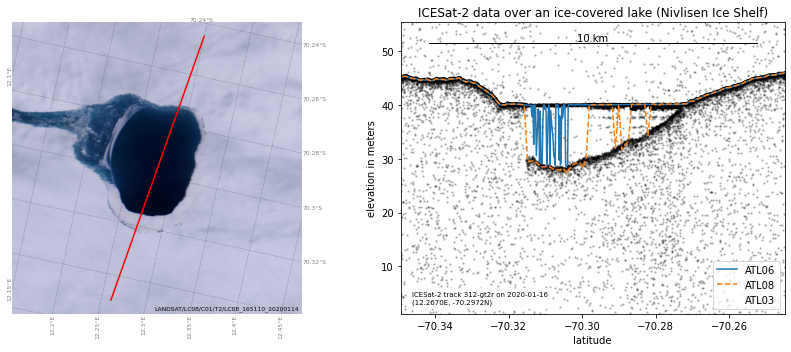

In [ ]:
myProductId = 'LANDSAT/LC08/C01/T2/LC08_165110_20200114' # <-- copy-pasted from above, after looking at the layers in the map
fig = mydata.plotDataAndMap(myProductId, crs='EPSG:3031', title='ICESat-2 data over an ice-covered lake (Nivlisen Ice Shelf)')

#**Example 2. Nearshore Bathmetry**

In [ ]:
url = 'http://openaltimetry.org/data/api/icesat2/atl12?date=2020-12-15&minx=-77.858681&miny=25.728091&maxx=-77.831461&maxy=25.832559&trackId=1254&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'

# initialize the dataCollector
myData = dataCollector(oaurl=url, beam=gtx)

In [ ]:
myData.makeGEEmap()

Data has not yet been requested from OpenAltimetry yet. Doing this now.
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.
The ground track is 11574 meters long.
Search for imagery from 2020-11-20 to 2021-01-09.
--> Number of scenes found within +/- 25 days of ICESat-2 overpass: 14
00: 2020-11-23 ( 22 days before ICESat-2 overpass): COPERNICUS/S2_SR/20201123T155531_20201123T155527_T18RTP
01: 2020-11-23 ( 22 days before ICESat-2 overpass): COPERNICUS/S2_SR/20201123T155531_20201123T155527_T17RRJ
02: 2020-11-28 ( 17 days before ICESat-2 overpass): COPERNICUS/S2_SR/20201128T155529_20201128T155525_T18RTP
03: 2020-11-28 ( 17 days before ICESat-2 overpass): COPERNICUS/S2_SR/20201128T155529_20201128T155525_T17RRJ
04: 2020-12-03 ( 12 days before ICESat-2 overpass): COPERNICUS/S2_SR/20201203T155521_20201203T155524_T18RTP
05: 2020-12-03 ( 12 days before ICESat-2 overpass): COPERNICUS/S2_SR/20201203T155521_20201203T155524_T17RRJ
06: 2020-12-

Map(center=[25.780558801013953, -77.84572201564868], controls=(WidgetControl(options=['position', 'transparent…

Downloaded downloads/COPERNICUS-S2_SR-20201213T155521_20201213T155522_T17RRJ-8bitRGB.tif
Saved plot to: plots/COPERNICUS-S2_SR-20201213T155521_20201213T155522_T17RRJ-8bitRGB-plot.jpg


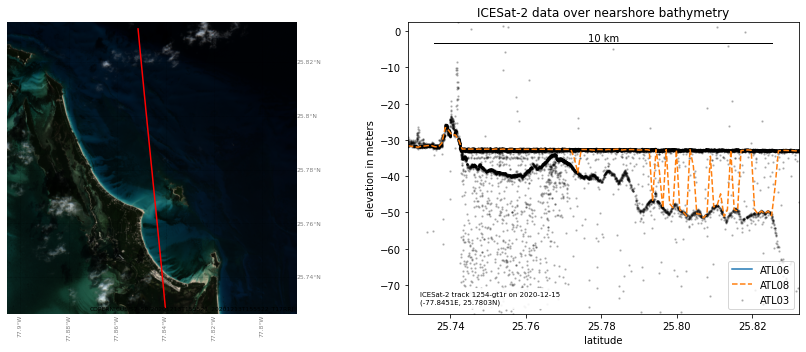

In [ ]:
scene_id='COPERNICUS/S2_SR/20201213T155521_20201213T155522_T17RRJ'
fig = myData.plotDataAndMap(scene_id, title='ICESat-2 data over nearshore bathymetry')

#**Example 3. Half Dome**

In [ ]:
url = 'http://openaltimetry.org/data/api/icesat2/atl06?date=2021-01-10&minx=-119.587886&miny=37.730067&maxx=-119.488871&maxy=37.775582&trackId=265&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2l'

# initialize the dataCollector
myData = dataCollector(oaurl=url, beam=gtx)

Data has not yet been requested from OpenAltimetry yet. Doing this now.
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.
Downloaded downloads/COPERNICUS-S2_SR-20210111T184739_20210111T184945_T10SGG-8bitRGB.tif
Saved plot to: plots/COPERNICUS-S2_SR-20210111T184739_20210111T184945_T10SGG-8bitRGB-plot.jpg


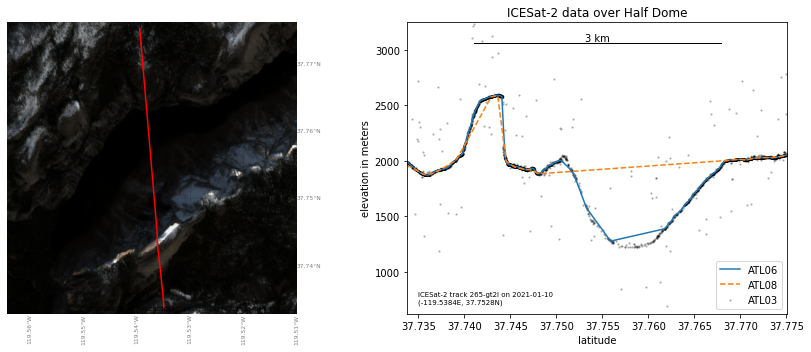

In [ ]:
scene_id='COPERNICUS/S2_SR/20210111T184739_20210111T184945_T10SGG'
fig = myData.plotDataAndMap(scene_id, title='ICESat-2 data over Half Dome')

#**Example 4. Ice Sehlf Rift**

In [ ]:
url = 'http://openaltimetry.org/data/api/icesat2/atl06?date=2020-01-26&minx=99.85237589431291&miny=-66.35086607273658&maxx=100.0381369994367&maxy=-66.19796463586664&trackId=476&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&outputFormat=json'
gtx = 'gt3r'

# initialize the dataCollector
myData = dataCollector(oaurl=url, beam=gtx)

Data has not yet been requested from OpenAltimetry yet. Doing this now.
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.
Downloaded downloads/LANDSAT-LC08-C01-T2-LC08_112107_20200127-8bitRGB.tif
Saved plot to: plots/LANDSAT-LC08-C01-T2-LC08_112107_20200127-8bitRGB-plot.jpg


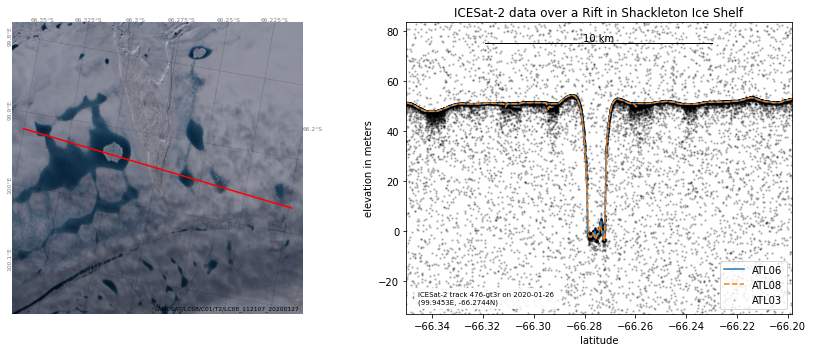

In [ ]:
scene_id='LANDSAT/LC08/C01/T2/LC08_112107_20200127'
fig = myData.plotDataAndMap(scene_id, crs='EPSG:3031', title='ICESat-2 data over a Rift in Shackleton Ice Shelf')

#**Example 5. Melt lake in Greenland**

In [ ]:
url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2019-08-22&minx=-22.184563606833546&miny=79.06859700015742&maxx=-21.876748966627616&maxy=79.1380278178076&trackId=848&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&outputFormat=json'
gtx = 'gt3l'
myData = dataCollector(oaurl=url, beam=gtx)
# myData.makeGEEmap()

Data has not yet been requested from OpenAltimetry yet. Doing this now.
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.
Downloaded downloads/COPERNICUS-S2_SR-20190823T152819_20190823T152813_T27XVH-8bitRGB.tif
Saved plot to: plots/COPERNICUS-S2_SR-20190823T152819_20190823T152813_T27XVH-8bitRGB-plot.jpg


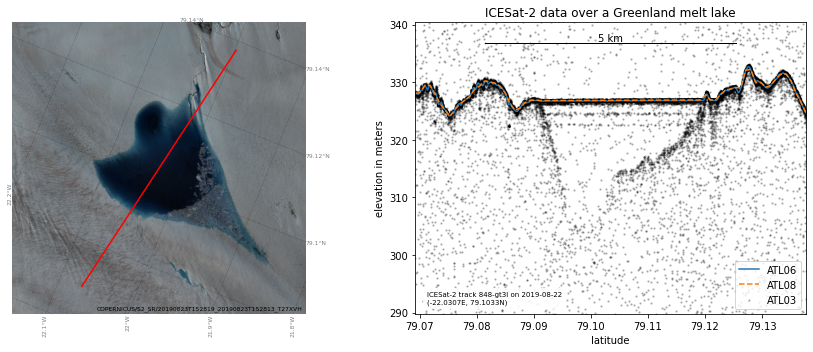

In [ ]:
scene_id='COPERNICUS/S2_SR/20190823T152819_20190823T152813_T27XVH'
fig = myData.plotDataAndMap(scene_id, crs='EPSG:3995', title='ICESat-2 data over a Greenland melt lake')

#**Example 6. Ice-covered lake on ice shelf**

In [ ]:
url = 'http://openaltimetry.org/data/api/icesat2/atl06?date=2019-05-15&minx=71.42728712317059&miny=-71.35245299984994&maxx=71.58501878594811&maxy=-71.26628346466289&trackId=721&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&outputFormat=json'
track = 721
gtx = 'gt3r'
latlims = [-71.35, -71.26]
lonlims = [71.41, 71.59]
myData = dataCollector(date='2019-05-15', track=track, beam=gtx, latlims=latlims, lonlims=lonlims)
# myData.makeGEEmap(days_buffer=60)

Data has not yet been requested from OpenAltimetry yet. Doing this now.
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.
Downloaded downloads/LANDSAT-LC08-C01-T2-LC08_127110_20190322-8bitRGB.tif
Saved plot to: plots/LANDSAT-LC08-C01-T2-LC08_127110_20190322-8bitRGB-plot.jpg


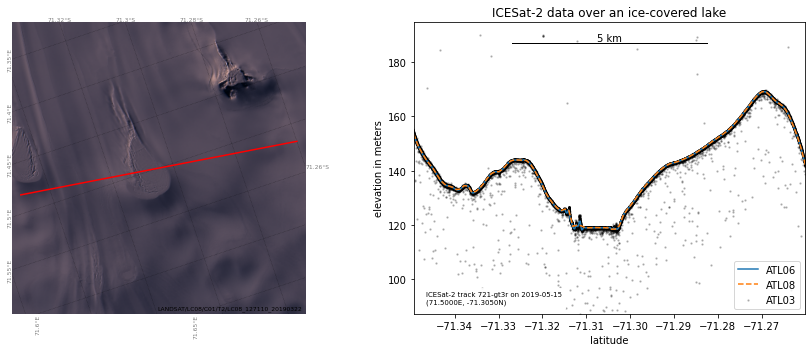

In [ ]:
scene_id='LANDSAT/LC08/C01/T2/LC08_127110_20190322'
fig = myData.plotDataAndMap(scene_id, crs='EPSG:3031', title='ICESat-2 data over an ice-covered lake')

#**Practice your own example**

In [ ]:
url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2020-07-15&minx=-98.22095910792066&miny=29.84239734550552&maxx=-98.19898645167066&maxy=29.884797705612943&trackId=302&beamName=gt1r&beamName=gt1l&outputFormat=json'

gtx = 'gt1r'
myData = dataCollector(oaurl=url, beam=gtx)

In [ ]:
myData.makeGEEmap(days_buffer=30)

Data has not yet been requested from OpenAltimetry yet. Doing this now.
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.
The ground track is 4425 meters long.
Search for imagery from 2020-06-15 to 2020-08-14.
--> Number of scenes found within +/- 30 days of ICESat-2 overpass: 12
00: 2020-06-18 ( 27 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200618T170849_20200618T171954_T14RNU
01: 2020-06-23 ( 22 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200623T170901_20200623T171555_T14RNU
02: 2020-06-28 ( 17 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200628T170849_20200628T171856_T14RNU
03: 2020-07-03 ( 12 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200703T170901_20200703T171739_T14RNU
04: 2020-07-08 (  7 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200708T170849_20200708T172504_T14RNU
05: 2020-07-13 (  2 days before ICESat-2 overpass): COPERNICUS/S2_SR/20200713T170901_20200713T171937_T14RNU
06: 2020-07-1

Map(center=[29.864635830166375, -98.21031181706458], controls=(WidgetControl(options=['position', 'transparent…

This file already exists, not downloading again: downloads/COPERNICUS-S2_SR-20200703T170901_20200703T171739_T14RNU-8bitRGB.tif
Saved plot to: plots/COPERNICUS-S2_SR-20200703T170901_20200703T171739_T14RNU-8bitRGB-plot.jpg


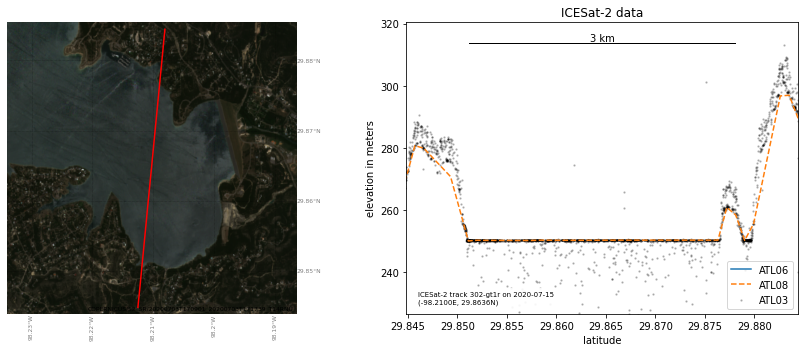

In [ ]:
scene_id='COPERNICUS/S2_SR/20200703T170901_20200703T171739_T14RNU'
fig = myData.plotDataAndMap(scene_id, crs='EPSG:3857', title='ICESat-2 data')

### Last update: 11/07/2022
### YoungHyun Koo (kooala317@gmail.com)